In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind , chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

this function take 3 inputs
* `dataset`: whole dataset. function expects data be integer or str.
* `alpha`: its the alpha for checking p-value of two sample t-test and chi^2 contingency test
* `categorical_col_names`: you gotta specify the categorical columns

this function find which columns have *Nan* values and after that for each column with *Nan* values it separate all rows with *Nan* values and other rows. so after this we have two dataframes, 1- all rows of a column is *Nan* 2- all rows contain some other values f.e integer or float. after that for each columns which contain continuous values it calculate t-test and check its p-value with `alpha` and if there is a column which affect our column with *Nan* values we append name of the culprit column in some list. and we calculate chi^2 contingency test for our categorical columns and do the same with its p-value as we did with p-values of t-test.

In [954]:
def best_combination(n): # finds the best shape for plots
    factors = [i for i in range(1, n + 1) if n % i == 0]
    THE_combination = None
    sum = np.inf

    for i in range(len(factors) // 2):
        one = factors[i]
        two = factors[-(i+1)]
        if (one + two) < sum:
            THE_combination = (one , two)

    return THE_combination


class missing_Values_check:
    
    def __init__(self , dataset: pd.DataFrame , alpha : int , categorical_col_names : list[str] = []):
        self.dataset = dataset
        self.columns_name = dataset.columns
        self.alpha = alpha
        self.bad_cols = []
        self.categorical_col_names = categorical_col_names
        self.res_p_values = {}

    def check_it(self):
        which_cols_isnan = self.dataset.isna().any()
        NaN_cols = self.columns_name[which_cols_isnan]
        p_values = [] # for chi^2 test

        for col in NaN_cols:
            with_nan_values = self.dataset[col].isna() # True value for Nan value and False for non-Nan values
            ds = self.dataset.drop(columns = col)
            categorical_ds = ds[self.categorical_col_names]
            continuous_ds = ds.drop(columns = self.categorical_col_names)
            continuous_columns = continuous_ds.columns

            # doing t test for continuous cols
            NaN_col = continuous_ds[with_nan_values]
            not_nan_col = continuous_ds[~with_nan_values] # not_nan_values.values
            
            t_test_Pvalues = ttest_ind(NaN_col , not_nan_col).pvalue
            is_bad_continuous_col = t_test_Pvalues < self.alpha # check p-value of t-test with our alpha
            bad_continuous_cols = continuous_columns[is_bad_continuous_col]
            if bad_continuous_cols.size > 0:
                self.bad_cols.append((f'{list(bad_continuous_cols)} affect {col}' , (bad_continuous_cols , col))) # appending the culprit column
                self.res_p_values[col] = dict(zip(bad_continuous_cols , t_test_Pvalues[is_bad_continuous_col]))

            # doing chi^2 test
            for col2 in self.categorical_col_names:
                categorical_col = categorical_ds[col2]
                contingency_table = pd.crosstab(index = with_nan_values , columns = categorical_col) # contingency table which contains frequency values, make one for better insight
                p_values.append(chi2_contingency(contingency_table).pvalue)

            is_bad_categorical_col = np.array(p_values) < self.alpha
            bad_categorical_cols = np.array(self.categorical_col_names)[is_bad_categorical_col]
            if bad_categorical_cols.size > 0:
                self.bad_cols.append((f'{list(bad_categorical_cols)} affect {col2}' , (bad_categorical_cols , col2)))
        
        if self.bad_cols == []:
            result = 'there are no bad columns'
        else:
            result = [res[0] for res in self.bad_cols]

        return result

    def show_proof(self):
        if self.bad_cols == []:
            return 'nothing to show'
        else:
            for _ , pair in self.bad_cols:
                affecting_cols = pair[0] # list of bad cols
                effected_col = pair[1] # name of effected col
                bad_col_len = len(affecting_cols)
                B = self.dataset[effected_col].isna()
                Nan_rows = self.dataset[B]
                NOT_Nan_rows = self.dataset[~B]

                combination = best_combination(bad_col_len)
                x = combination[0]
                y = combination[1]

                fig = plt.figure(figsize = (14 , 11) , constrained_layout = True)
                fig.suptitle(f'columns which affect {effected_col} column' , size = 21 , y = 1.08)
                subfigs = fig.subfigures(nrows = x , ncols = y , wspace = 0.15)

                for (outer , subfig) , bad_col in zip(enumerate(subfigs.flat) , affecting_cols):
                    axs = subfig.subplots(nrows = 3 , ncols = 1)
                    subfig.suptitle(bad_col , size = 17 , y = 1.03)
                    subfig.constrained_layout = True
                    subfig.text(0.25 , -0.02 , f'p value = {self.res_p_values[effected_col][bad_col]}')

                    for inner , ax in enumerate(axs.flat):
                        if inner == 0:
                            if bad_col in self.categorical_col_names:
                                NOT_Nan_val_counts = NOT_Nan_rows[bad_col].value_counts()
                                sns.barplot(NOT_Nan_val_counts , ax = ax)
                                ax.set_xlabel(None)
                                ax.set_title('Not Nan')
                            else:
                                NOT_Nan_val_counts = NOT_Nan_rows[bad_col]
                                sns.histplot(NOT_Nan_val_counts , kde = True , ax = ax)
                                ax.set_xlabel(None)
                                ax.set_title('Not Nan')
                                ax.text

                        elif inner == 1:
                            if bad_col in self.categorical_col_names:
                                Nan_val_counts = Nan_rows[bad_col].value_counts()
                                sns.barplot(Nan_val_counts , ax = ax)
                                ax.set_xlabel(None)
                                ax.set_title('Nan')
                            else:
                                Nan_val_counts = Nan_rows[bad_col]
                                sns.histplot(Nan_val_counts , kde = True , ax = ax)
                                ax.set_xlabel(None)
                                ax.set_title('Nan')

                        elif inner == 2:
                            if bad_col in self.categorical_col_names:
                                Nan_val_counts = Nan_rows[bad_col].value_counts()
                                NOT_Nan_val_counts = NOT_Nan_rows[bad_col].value_counts()
                                sns.barplot(Nan_val_counts , ax = ax , color = 'blue')
                                sns.barplot(NOT_Nan_val_counts , ax = ax , color = 'indianred')
                                ax.set_xlabel(None)
                                ax.legend(['Nan' , 'Not Nan'])
                                ax.set_title('both')
                            else:
                                Nan_val_counts = Nan_rows[bad_col]
                                NOT_Nan_val_counts = NOT_Nan_rows[bad_col]
                                sns.histplot(Nan_val_counts , kde = True , ax = ax , color = 'blue')
                                sns.histplot(NOT_Nan_val_counts ,kde = True , ax = ax , color = 'indianred')
                                ax.set_xlabel(None)
                                ax.legend(['Nan' , 'Not Nan'])
                                ax.set_title('both')

                plt.show()                     

In [955]:
housing = pd.read_csv("D:/datasets/housing/housing.csv")

In [956]:
E = missing_Values_check(dataset = housing , alpha = 0.05 , categorical_col_names = ['ocean_proximity'])
E.check_it()

'there are no bad columns'

In [957]:
E.show_proof()

'nothing to show'

In [958]:
p = pd.read_csv('D:\\datasets\\Airdata\\Airdata.csv')

In [959]:
p = p.drop('DateTime' , axis = 1)

In [960]:
Z = missing_Values_check(dataset = p , alpha = 0.05)
Z.check_it()

["['Temperature', 'Wind_Speed', 'Wind_Direction'] affect NO2_Location_B",
 "['Temperature', 'Humidity', 'Wind_Speed'] affect NO2_Location_C"]

c:\Users\msmj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\msmj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\msmj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\msmj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: us

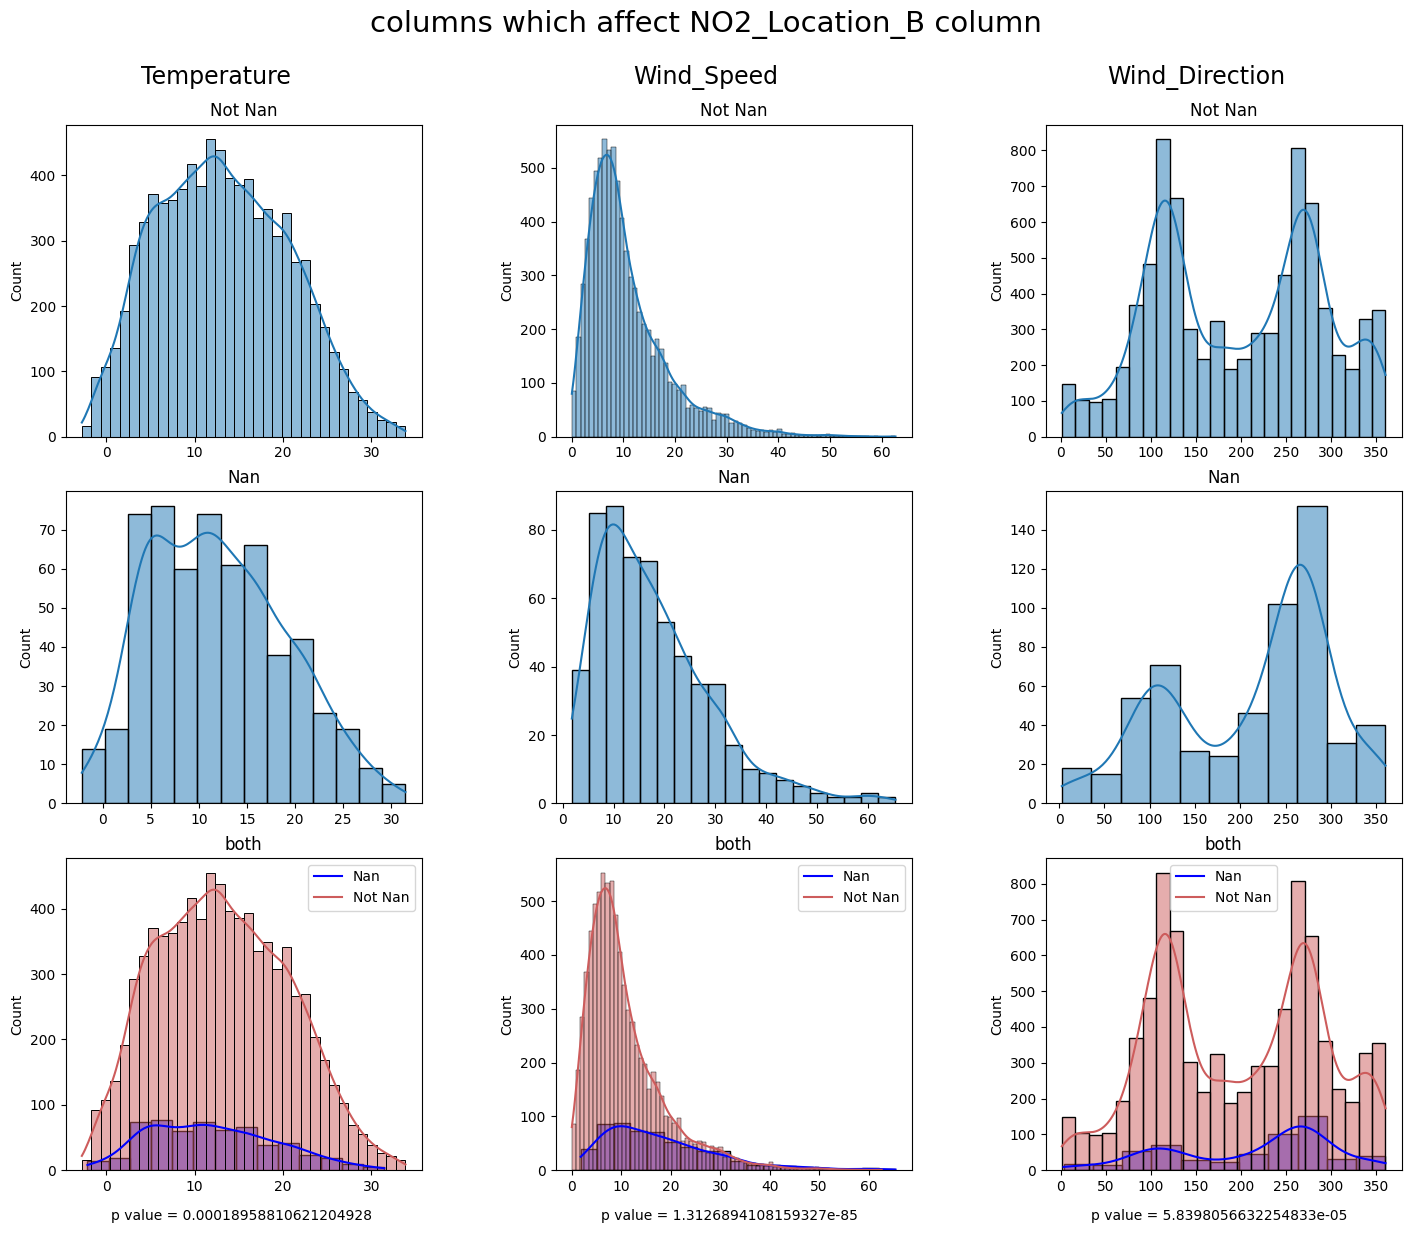

c:\Users\msmj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\msmj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\msmj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\msmj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: us

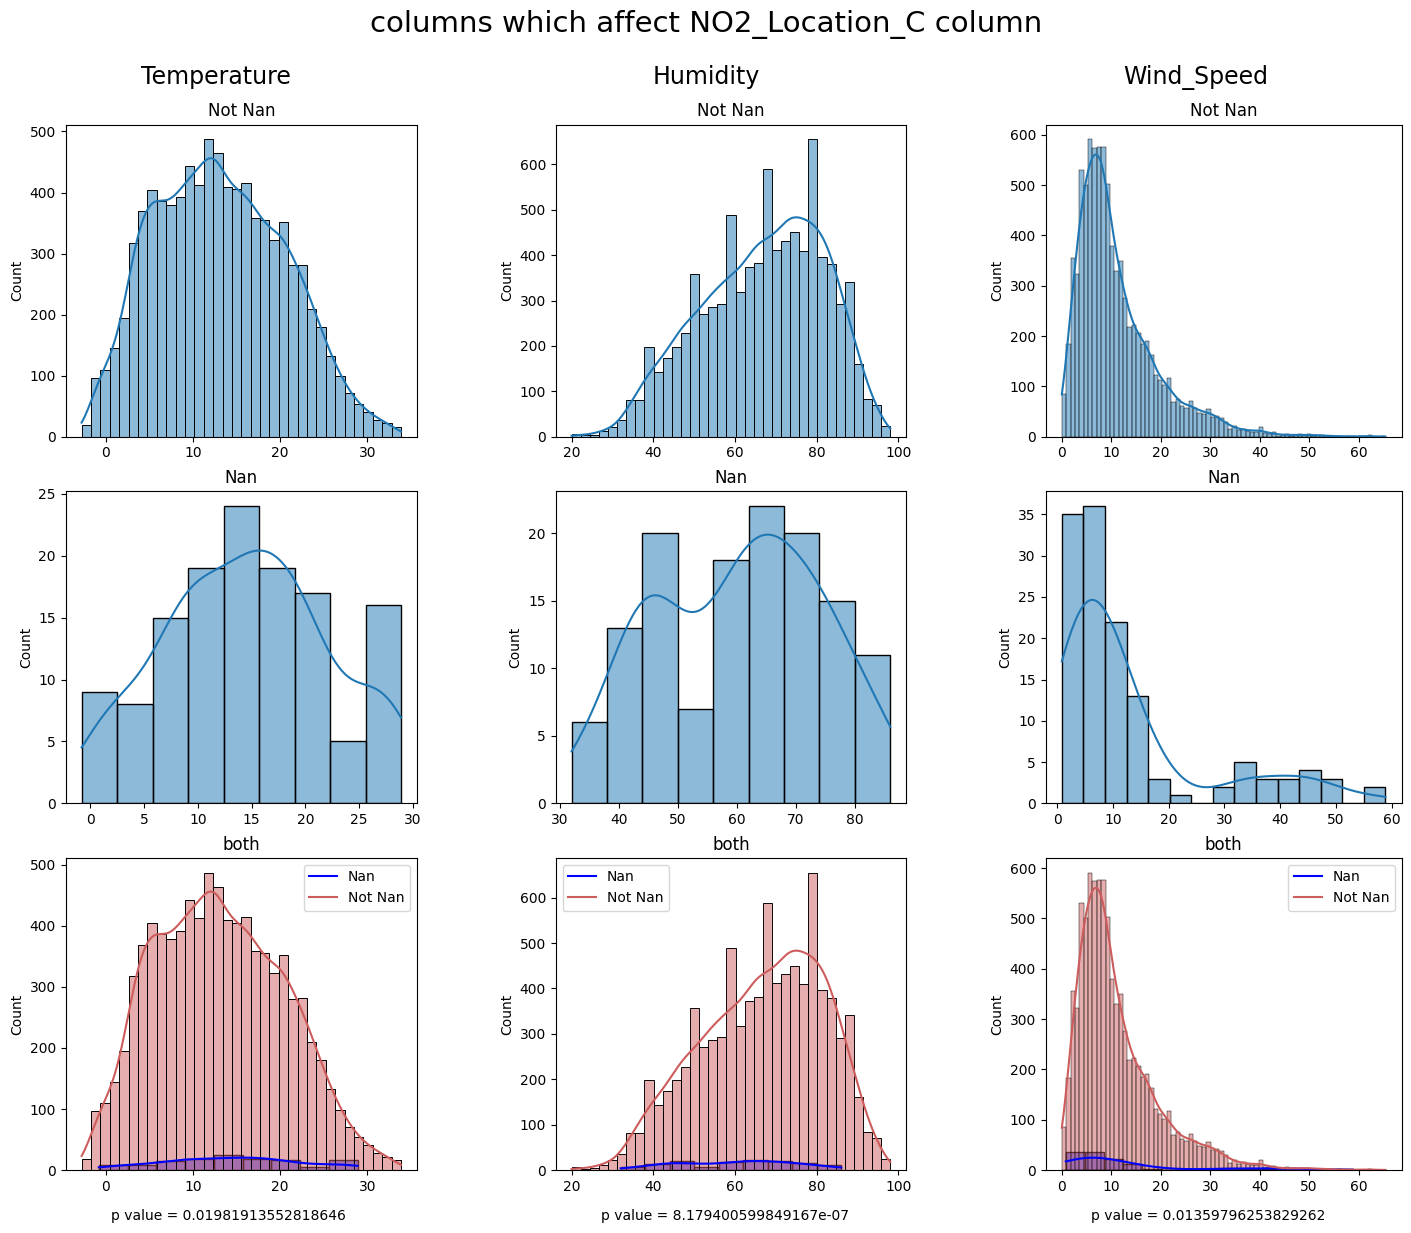

In [961]:
Z.show_proof()